# Some Numerical Experiments for Entropy Estimation in our data

## 1) Introduction

Electroneurophysiology is strongly based on the measurement and characterization of electrical signals given by live neurons, either *in vitro* or *in vivo*. This signal is offten recorded as a succesion on varying voltage measurements, done at precise, high frequencies. Along the years, the sampling and precision of these measurements have increased by several orders of magnitude. Moreover, the capacity to sample hundreds or thousands of sites simultaneously exists now, somethimes spread over macroscopic areas, such as the whole scalp of the head, or concentrated in very small areas, as in MMEAs (Massive Microelectrodes arrays). Such signals are very rich, and many efforts are done to characterize their complexity. The very first approach usually is to estimate the Entropy of the signal, and from there to use other derived measures such as Mutual Information or Transfer Entropy to search for causality between different channels. 

It turns out that the very first step is sometimes done routinelly and without much thought to fundamentals, and, as we shall show here, can lead to very different results if its done without care. As we shall see, Entropy in the sense of Shannon can easilly  be wrongly applied, either due to conceptual laxitude or by error in the numerical algorithmic design. On the other hand, slighlty different calculations of Entropy may point different "complexities" in the data. As we are most interested in causality tests, we may focus on the most consisten and robusts Entropies. 


## 2) Shannon Entropy

Shannon Entropy was devised as Shannon as a measure of the compexity of a message encoded in discrete symbols. This is very important because its strict definition works very well in the case that the symbolization is given, but it fails ( spectacularly one may say ) if one takes instead a posible continuum of symbols. Another caveat, often overlooked when one makes the transission to the continuum case is that a random distribution is in some sense invariant to temporal orderings. One could in principle regard a signal as a sampling of random variables, reorder them, and obtain the same distribution, and thus, the same entropy. As an example, we could take every letter, punctiation mark and space of this parragraph, garble them into nonsense, and claim that they have the same Entropy as the original parragraph, and therefore, the same Information, which is as much nonsense as the random letters. But actually this is done implicitly in a lot of numerical estimations of Entropy.
Let us remember Shannon's original definition. Suppose that we have a set of discrete symbols, that is, a series of separeted, well defined values, which could be letters, digits, or any other symbol of such a kind. For simplicty we represent them as numbers, so $n$ discrete symbols would be $\{1, 2, \ldots n \}$. Suppose that we have a random process that picks those symbols and gives us a string of them. Such a string would be called a "message". Now let us suppose that the process is ergodic, that means, a very long "message" would be a good representation of the probabilities of the process that picks the symbols. Rigourosly speaking, the process would eventually be able to produce all the possible messages that those symbols permit, and their frecuencys would represent the probabilites of the random process. If we knew preciselly the probabilities $p$ of every symbol $s_j$, the entropy would be:
$$
H=\sum_{j=1}^n p(s_j) \log (p (s_j))
$$
The base of the logarythm is usually taken as two, in which case the Entropy has as units the bit. In that case it can be interpreted as the average number of binary option question one has to make to guess symbol correctly.  A change of base of the logarythm is simply a change of units. 
The first conundrum is that we may not have the knowledge of the $p(s_j)$ directly, so we must infer them from the messages that we sample, and by doing so we may say that we are meassuring the Entropy of the messages and not of the process. 

Shanon in his original paper stated that the same idea could be done by extending it to continous distributions:
$$
H=\int p(x) \log(x) d x
$$
for a random continous variable and a probability distribution $p(x)$. It turns out that the limit does not converge, and one could make some algebraic tricks to make it converge, but that would affect the interpretation. Nevertheless, this is the formula that one encounters cited most often in the electrophysiological literature regarding pseudo continous signals, and that is the address of our critique. 

## Binarization of the Data and Symbolic Sequences

Researches take at face value the last equation and try to make a numerical aproximation to it. This is achieved first by estimating the distribution function of pseudo continous data. The usuall approach is first to make an histogram of the data. By so doing one is actually making a symbolization of the data ( called binarization, from bins, not from binary digits ), and if one applies Shannon's formula, then one is actually calculating the entropy of the sequences from that specific binarization. One could optimistically think that such a calculation could be a reasonable approach to a limiting form of the Entropy, but that is not the case. A lot of hidden effects arise due to the binarization process as we shall exemplify below. 

### A numerical example

We shall show some calculations derived from using naively the mentioned approach. Our data comes from electrophysiological experiments, recorded with the BioCAM form BrainWave, a MMEA that has 4095 recording electrodes over an area of 2.27mm by 2.27 mm. In the data shown below, the data sampling rate was of 7.022 KHz.

In [1]:
# some auxiliary libraryes for ploting and dealing with HDF5 files
using HDF5, StatsBase, Statistics,PyPlot
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools, OrdenaSets

In [2]:
# A recording of an experiment with facilitated activity, due to an induced cortical lesion.
arxname="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

In [3]:
# file variables
arx=h5open(arxname)
names(arx)

7-element Array{String,1}:
 "CSDALindenberg"
 "CanalesBuenos"
 "CanalesMalos"
 "LFPSaturados"
 "desde"
 "freq"
 "hasta"

This data has been allready been preprocessed. That means that we have a list of putative active channels, and of unusable channels. The recording is given to the variable lfp, which is an array of floating point numbers.

In [4]:
canales=read(arx["CanalesBuenos"])
malos=read(arx["CanalesMalos"])
#lfp=read(arx["dset"]);
lfp=read(arx["LFPSaturados"]);
#freq=read(arx["SamplingRate"])/1000
freq=read(arx["freq"])

dd=size(lfp)
if length(dd)==2
    nmax=dd[2]
    lfp=reshape(lfp, 64,64,nmax)
end
nmax=size(lfp,3)
typeof(lfp)

Array{Float32,3}

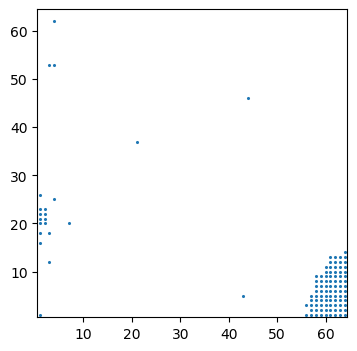

PyObject <matplotlib.collections.PathCollection object at 0x7f5167043910>

In [5]:
# The localization of the unusable channes in the MMEA
ff=figure(figsize=(4,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
# Isabel Nuevos
#scatter(canales[:,3], canales[:,2], s=0.5)
#Franco Viejos
scatter(malos[:,2], malos[:,1], s=1.5)

In [7]:
# a helper array to contain all "non bad" channels
mm=rowstoset(malos)
nomalos=zeros(4096,2)
for j=1:64, k=1:64
    nomalos[(j-1)*64+k,1]=j
    nomalos[(j-1)*64+k,2]=k
end
nomm=rowstoset(nomalos)
setdiff!(nomm, mm);
bb=rowstoset(canales)
nomalosnibuenos=setdiff(nomm,bb);

In [8]:
include("../Preprocesamiento/SpikeDetect01.jl")

spikedetect (generic function with 1 method)

In [11]:
nnspikes=zeros(Int32, 64,64)
for j=1:64, k=1:64
    nnspikes[j,k]=length(spikedetect(lfp[j,k,:], umbra=-120))
end

A quick visual test to show the channels which have spikes detected on them. The higher counts fall over he CA3 region of the hippocampus.

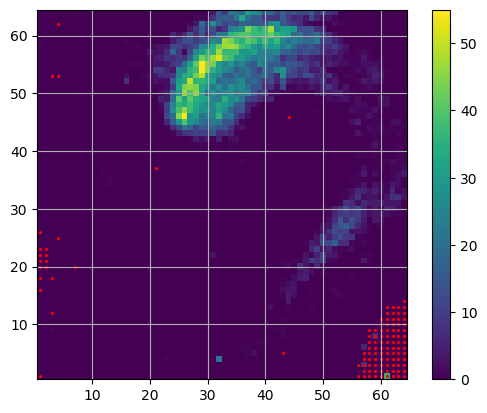

In [12]:
bla=imshow(nnspikes, origin="lower", extent=[0.5,64.5, 0.5,64.5])
colorbar(bla)
scatter(malos[:,2], malos[:,1], s=1.5, color="red")
grid()

In [13]:
lfpex=lfp[53,29,:];
sus=spikedetect(lfpex, umbra=-100);
susstd=spikedetect(lfpex);

Here we show the trace of the recording in microVolts for an exemplary channel. The spike detection shows the point of maximal negative deflection from the basal noise.

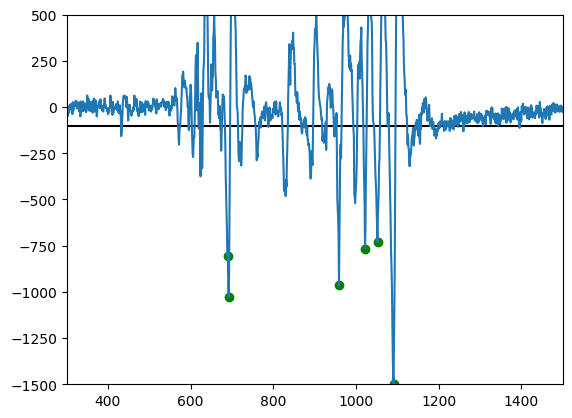

PyObject <matplotlib.collections.PathCollection object at 0x7f5166ac8b50>

In [14]:
figure()
ylim(-1500,500)
xlim(300, 1500)
plot(lfpex)
hlines(-100,xmin=1, xmax=2000)
#scatter(sus, lfpex[sus], color="red")
scatter(susstd, lfpex[susstd], color="green")


In [64]:
lfpraro=lfp[4,32,:]

2000-element Array{Float32,1}:
  12.084961
 -40.283203
   0.0
  24.169922
 -12.084961
  -8.056641
 -58.410645
  -6.0424805
 -16.113281
  -4.0283203
   8.056641
  -2.0141602
  18.127441
   ⋮
  24.169922
  44.311523
  16.113281
  12.084961
  48.339844
  34.240723
  -6.0424805
  18.127441
 -14.099121
  -6.0424805
  14.099121
  30.212402

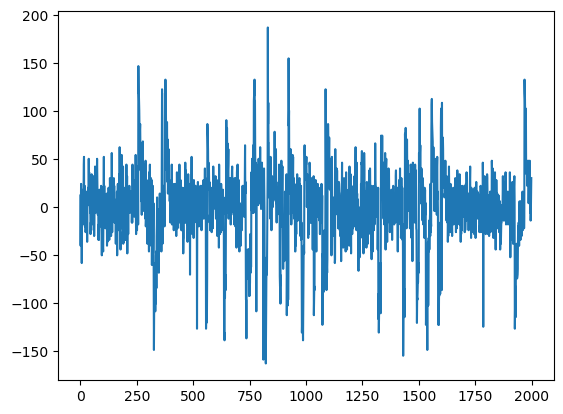

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7a70f1bd90>

In [66]:
f=figure()
#ylim(-1000,1000)
#xlim(1,750)
plot(lfpraro)

In [71]:
lfpchorizo=[0]

for q in nomm
    j=q[1]
    k=q[2]
    lfpex=vec(lfp[j,k,:])
    lfpchorizo=vcat(lfpchorizo, lfpex)
end


In [73]:
std(lfpchorizo)

59.315647f0

In [75]:
lfpchorizoruido=[0]

for q in nomalosnibuenos
    j=q[1]
    k=q[2]
    lfpex=vec(lfp[j,k,:])
    lfpchorizoruido=vcat(lfpchorizoruido, lfpex)
end

In [76]:
std(lfpchorizoruido)

21.146173f0

In [27]:
hruido=countmap(lfpchorizoruido)
druido=dictarrayordenado(hruido)

UndefVarError: UndefVarError: dictarrayordenado not defined

In [26]:
xlim(-100,100)
plot(druido[:,1], druido[:,2])

paso=11*deltaV

for bla=-deltaV*45:paso:0
#vlines(-bla,0,400)
vlines(bla,0,400000)
end


for bla=0:paso:99
#vlines(-bla,0,400)
vlines(bla,0,400000)
end


UndefVarError: UndefVarError: druido not defined

In [35]:
ver=countmap(lfpchorizo)
eso=sort(collect(keys(ver)))

1144-element Array{Float32,1}:
 -1703.9795
 -1663.6963
 -1621.3989
 -1613.3423
 -1611.3281
 -1589.1724
 -1581.1157
 -1571.0449
 -1552.9175
 -1544.8608
 -1528.7476
 -1504.5776
 -1498.5352
     ⋮     
  1369.6289
  1389.7705
  1391.7847
  1393.7988
  1397.8271
  1405.8838
  1460.2661
  1480.4077
  1492.4927
  1528.7476
  1550.9033
  4122.986 

In [35]:
print(eso)

UndefVarError: UndefVarError: eso not defined

In [38]:
delta * 2.0141602

UndefVarError: UndefVarError: delta not defined

In [38]:
deltaV=2.0141602

2.0141602

In [39]:
11*deltaV

22.1557622

In [28]:
lfpmean=zeros(nmax)
n=0
for q in nomm
    j=q[1]
    k=q[2]
    lfpex=vec(lfp[j,k,:])
    lfpmean.+=lfpex
    n+=1
end
lfpmean./=n;

In [29]:
lfpsubbuenos=Dict{Any, Array}()
todo=1:5:size(canales,1)

for pieza in todo[1:end-1]
    rang=pieza:pieza+5
    aux=[0]
    for q in rang
    j=canales[q,1]
    k=canales[q,2]
    lfpex=vec(lfp[j,k,:])
    aux=vcat(aux, lfpex)
    end
    lfpsubbuenos[rang]=aux[2:end]
end

In [30]:
length(lfpsubbuenos)

211

In [31]:
function dictarrayordenado(dd::Dict)
    llaves=sort(collect(keys(dd)))
    nnll=length(llaves)
    result=zeros(nnll,2)
    for k in 1:nnll
        result[k,1]=llaves[k]
        result[k,2]=dd[llaves[k]]
    end
    #result=result[sortperm(result[:, 1]), :]
    return result
end

dictarrayordenado (generic function with 1 method)

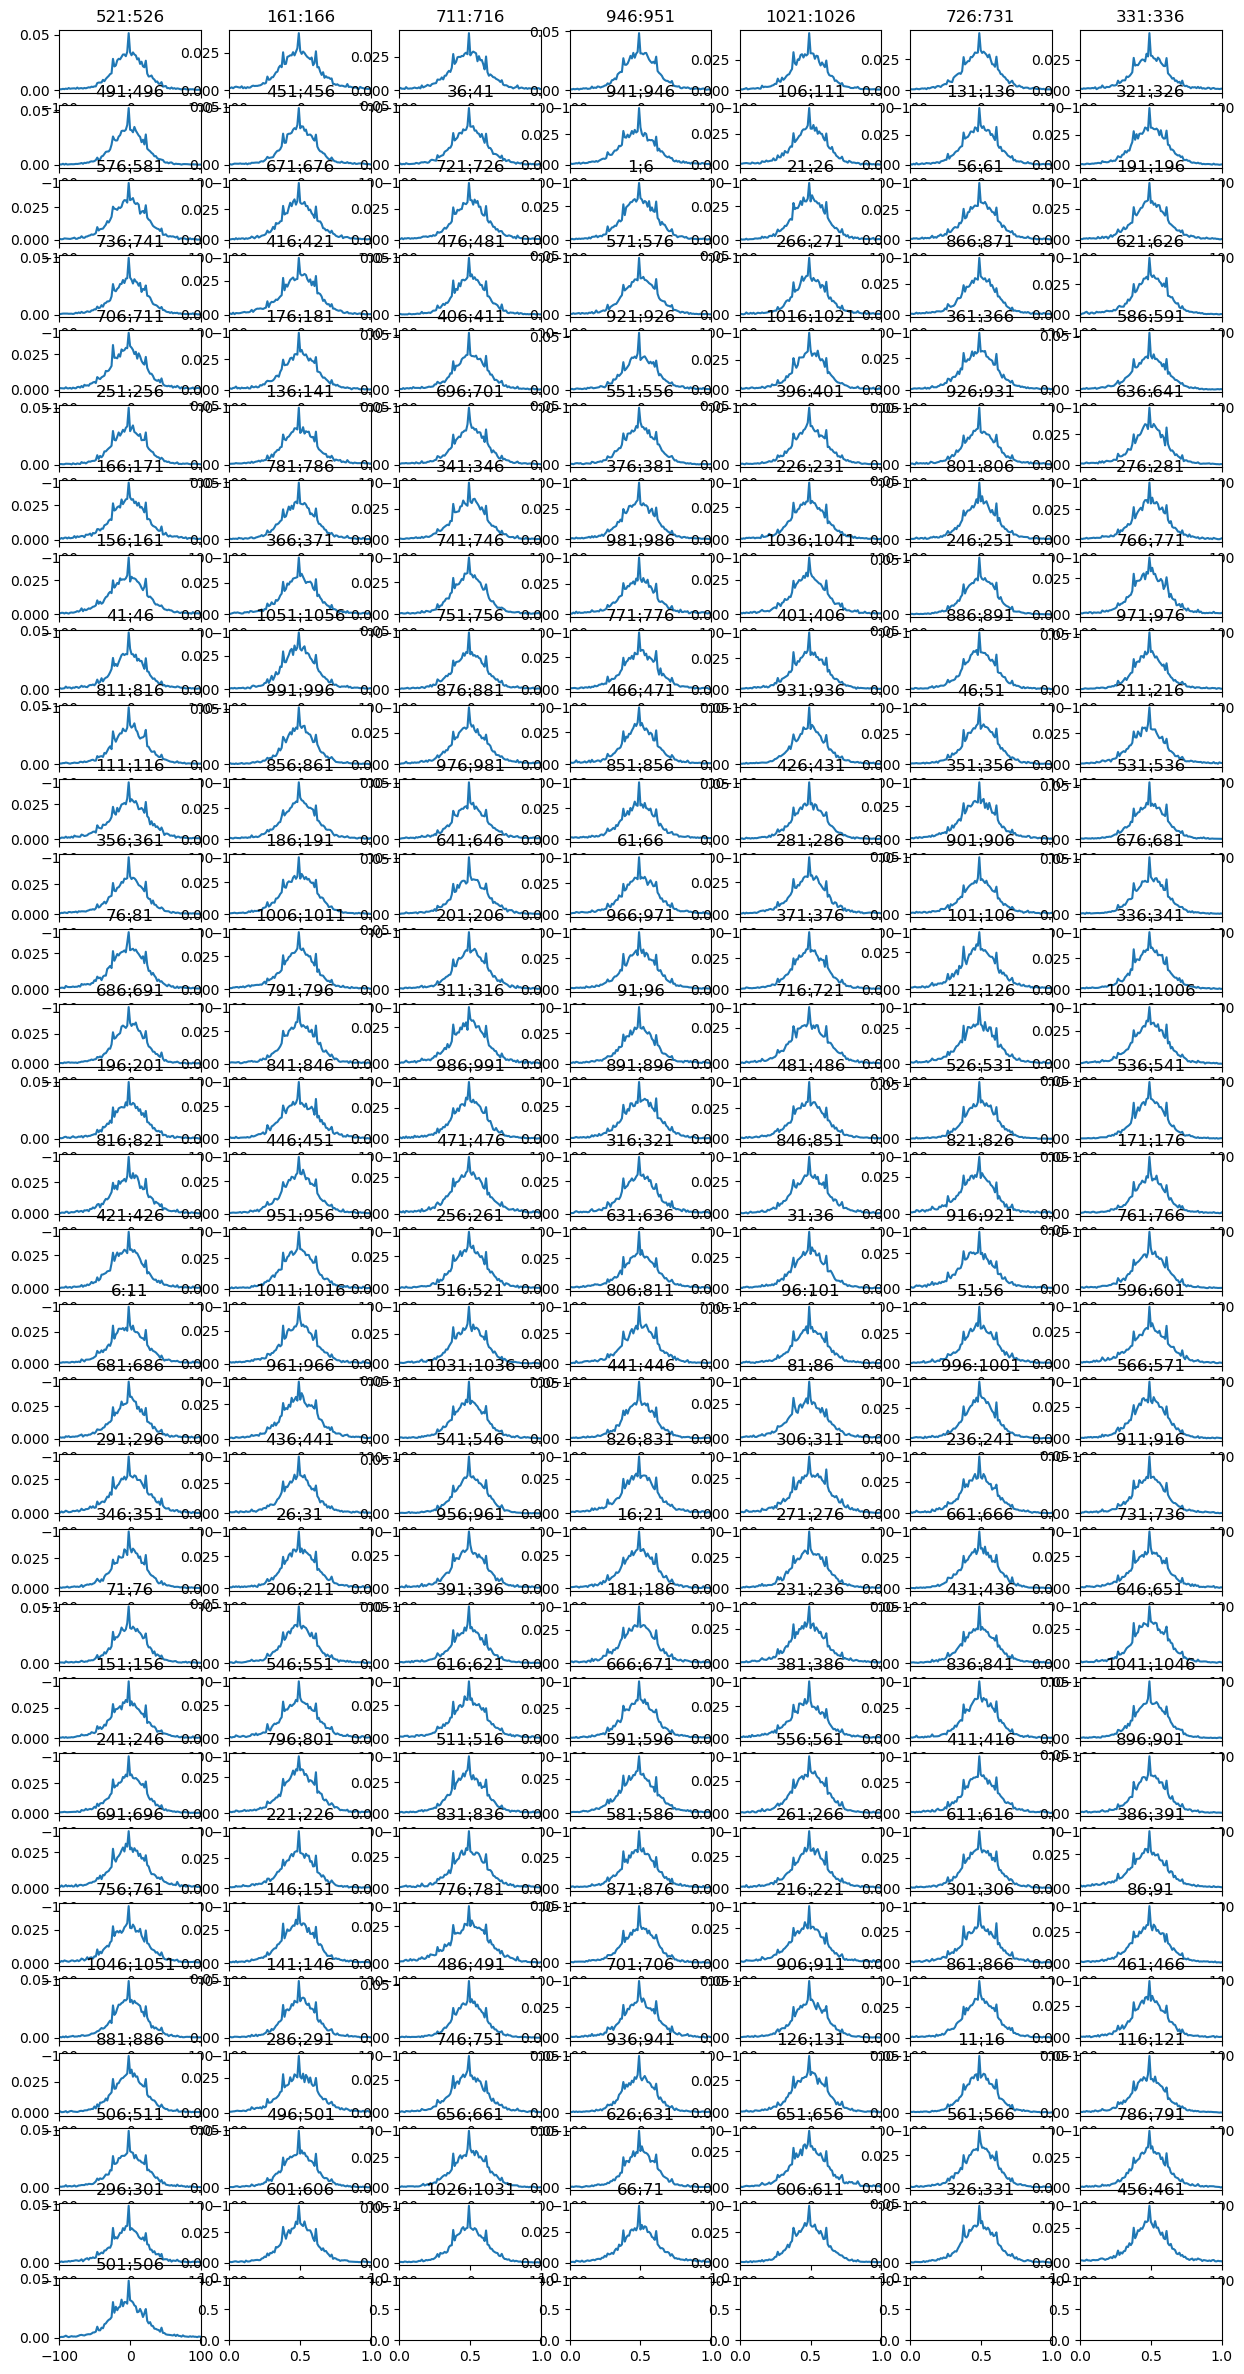

211

In [32]:
fig, supp=subplots(31,7, figsize=(15,30))

k=0

for ke in keys(lfpsubbuenos)
    (j,l)=(divrem(k,7)).+1
    #println(j," ",  l)
    
    mm=countmap(lfpsubbuenos[ke])
    ddd=dictarrayordenado(mm)
    ddd[:,2]=ddd[:,2]./sum(ddd[:,2])
    supp[j,l].set_xlim(-100,100)
    supp[j,l].plot(ddd[:,1], ddd[:,2])
    supp[j,l].set_title("$ke")
    
    k+=1
end
print(k)

In [33]:
firo=figure(figsize=(12,10))

xlim(-100,100)
  
k=0
for ke in keys(lfpsubbuenos)
    mm=countmap(lfpsubbuenos[ke])
    ddd=dictarrayordenado(mm)
  #  ddd[:,2]=ddd[:,2]./sum(ddd[:,2])
    plot(ddd[:,1], ddd[:,2], lw=0.1, c=(k/210,0,0))
    
    k+=1
end

paso=11*deltaV

for bla=-deltaV*45:paso:0
#vlines(-bla,0,400)
vlines(bla,0,400)
end


for bla=0:paso:99
#vlines(-bla,0,400)
vlines(bla,0,400)
end

print(k)

UndefVarError: UndefVarError: deltaV not defined

In [34]:
-deltaV*45+4*paso

UndefVarError: UndefVarError: deltaV not defined

In [11]:
mean(lfpsubbuenos), std(lfpsubbuenos), iqr(lfpsubbuenos)

(-1.8787115f0, 58.424725f0, 36.2548828125)

In [10]:
mean(lfpchorizo), std(lfpchorizo), iqr(lfpchorizo)

(-1.5094328f0, 35.0429f0, 30.21240234375)

In [11]:
mean(lfpmean), std(lfpmean), iqr(lfpmean)

(-1.5094330838709866, 6.699117754488354, 8.663318420241424)

In [12]:
extrema(lfpmean),extrema(lfpchorizo)

((-24.303558035153305, 23.874808687994786), (-1621.3989f0, 4122.986f0))

In [32]:
cmptodos=countmap(lfpchorizo)
cmpbuenos=countmap(lfpchorizobuenos);

In [49]:
dtodos=dictarrayordenado(cmptodos)
dbuenos=dictarrayordenado(cmpbuenos);
dtodos[:,2]=dtodos[:,2]./sum(dtodos[:,2])
dbuenos[:,2]=dbuenos[:,2]./sum(dbuenos[:,2])


1123-element Array{Float64,1}:
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 ⋮                    
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 4.7619024943321456e-7
 2.3809512471660728e-5

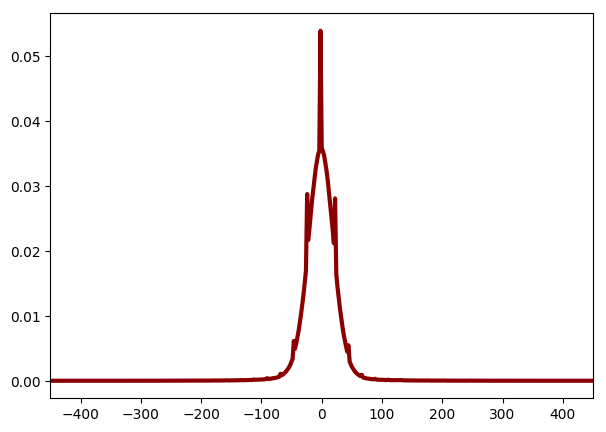

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff6a7e590b8>

In [86]:
figure(figsize=(7,5))
xlim(-450,450)
#for k=1:30

  #   plot(dbuenos[:,1], dbuenos[:,2].+k*0.0002, lw=0.3, c=(k/30,0,0))
#end
plot(dtodos[:,1], dtodos[:,2], lw=3, c="darkred")


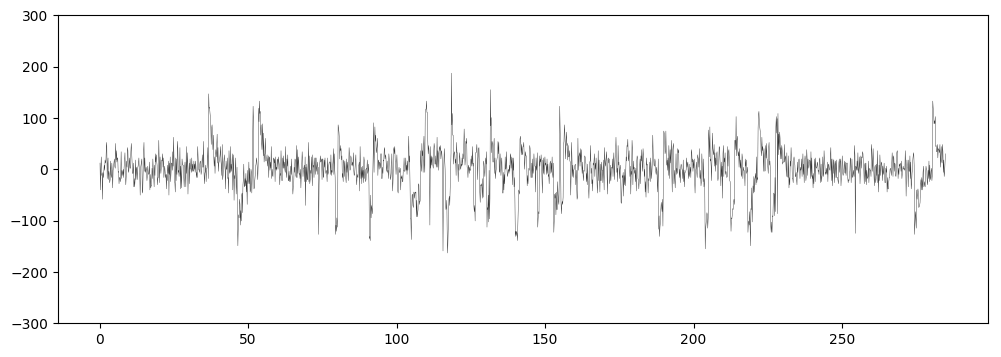

4 32 bla

In [111]:
figi=figure(figsize=(12,4))

ylim(-300,300)



#for q in 1:size(canales,1)
rau=25
rango=(5:5).+rau
for q in rango

    j=canales[q,1]
    k=canales[q,2]
    lfpex=vec(lfp[j,k,:])
    tiempo=(1:nmax)./freq
    plot(tiempo,lfpex, lw=0.3, c=(0.2,0.2,0.2))
    print(j, " ", k, " bla")
end
#figi.patch.set_facecolor("xkcd:salmon")
#figi.patch.set_facecolor((1.0, 0.47, 0.42))

In [87]:
size(canales,1)

1050

In [13]:
function renormvec(datos::Array)
    mu=mean(datos)
    result=datos.-mu
    sig=std(result)
    if sig !=0
    result=result./sig
    end
    return result
end

renormvec (generic function with 1 method)

In [14]:
cbrt(2000)

12.599210498948732

In [15]:
lfprn=zeros(size(lfp))
for j=1:64, k=1:64
    lfprn[j,k,:]=renormvec(lfp[j,k,:])
end

In [16]:
yxref=[39,40]
# okey menso a barreconjunto le tienes que pasar solo las columnas con coordenadas!!!
orderchans=barreconjuntoyordena(canales[:,1:2], yxref);

alfamin = 0.015623728620476831


In [17]:
v=orderchans[:,2].==40
orderchans[v,:]

19×3 Array{Int64,2}:
 51  40   408
 50  40   409
 49  40   410
 47  40   411
 46  40   412
 64  40   413
 63  40   414
 62  40   415
 61  40   416
 60  40   417
 59  40   418
 58  40   419
 57  40   420
 56  40   421
 55  40   422
 54  40   423
 53  40   424
 52  40   425
  7  40  1019

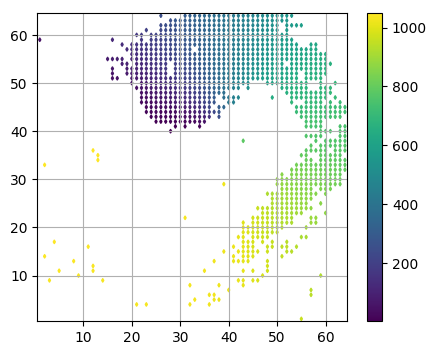

In [18]:
ff=figure(figsize=(5,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
#scatter(canales[:,2], canales[:,1], s=0.5)
scatter(orderchans[:,2], orderchans[:,1], marker="d",s=3, cmap="viridis", c=orderchans[:,3])
colorbar()
grid()

In [19]:
ejemplos=([58,30], [56,41], [54,36],[14,40])

([58, 30], [56, 41], [54, 36], [14, 40])

In [20]:
function freediaconisbin(datos)
    # Freedman and Diaconis
    n=length(datos)
    m=iqr(datos)
    result=2*m/cbrt(n)
    return result
end

function scottbin(datos)
    n=length(datos)
    m=std(datos)
    result=3.49*m/cbrt(n)
end

function sqrbin(datos)
    n=length(datos)
    sq=sqrt(n)
    (mir,mar)=extrema(datos)
    result=(mar-mir)/sq
end

function mejorbin(datos; deltax=1)
    # estas asumiendo que los datos se ven bastante gaussianos!
    # y que estan discretizados en pasos deltax

    (fd, sb, sq)=(freediaconisbin(datos), scottbin(datos), sqrbin(datos))
    bines=[fd, sb, sq, sig]
    nombins=["fd", "sb", "sq", "sig"]
    # pa debuquear
    bines=[sq]
    nombins=["sq"]
    
    masquedx=bines[bines.>deltax]
    nommas=nombins[bines.>deltax]
    if isempty(masquedx)
        result=("dd", deltax) 
    else 
        aver=findmin(masquedx)
        elbueno=nommas[aver[2]]
        elbuenon=aver[1]
       result=(elbueno, elbuenon)
    end
    return result
end

function fuu(x::String)
    result=0
    if x=="dd"
        result=0
    elseif x=="fd"
        result=1
    elseif x=="sb"
        result=2
    elseif x=="sq"
        result=3
    elseif x=="sig"
        result=4
    end
    return result
end

fuu (generic function with 1 method)

In [21]:
function histoptimo(datos::Array; deltax=1)
    bine=mejorbin(datos, deltax=deltax)
    (vmin,vmax)=extrema(datos)
    rango=vmin:bine:vmax+bine
    result=fit(Histogram, datos,rango)
end

function histobin(datos::Array; deltax=1, method="none")
  
    if method=="none"
        bin=deltax
    elseif method=="fd"
        bin=freediaconisbin(datos)
   elseif method=="sb"
        bin=scottbin(datos)
    elseif method=="sq"
        bin=sqrbin(datos)
    end
    
    if bin==0
        bin=deltax
    end
    (vmin, vmax)=extrema(datos)
    rango=vmin:bin:vmax+bin
    h=fit(Histogram, datos, rango)
    result=(bin,h)
end

function histoheuristic(datos::Array, bin=4.7)
    vmin,vmax=(-2000,2000)
    n=length(datos)
    rango=vmin:bin:vmax+bin
    h=fit(Histogram, datos, rango)
    result=(bin,h)
end




histoheuristic (generic function with 2 methods)

In [24]:
entrocountmap=zeros(64,64)
ncountmap=zeros(64,64)

for j=1:64,k=1:64
    dict=countmap(lfp[j,k,:])
    valores=values(dict)
    pesos=valores./sum(valores)
    entrocountmap[j,k]=entropy(pesos)
    ncountmap[j,k]=length(valores)
end

In [23]:

comparaentropias=zeros(64,64,4)
metos=["fd", "sb", "sq", "heu"]
bines=[0,0,0,0]

for m in 1:3
    metodo=metos[m]
    for j=1:64,k=1:64
        lfpex=vec(lfp[j,k,:])
     #   println("$j, $k, $metodo")
        hhh=histobin(lfpex, method=metodo)
        hwei=hhh[2].weights./sum(hhh[2].weights)
        comparaentropias[j,k,m]=entropy(hwei)
    end
end

m=4
metodo=metos[m]
    for j=1:64,k=1:64
        lfpex=vec(lfp[j,k,:])
        hhh=histoheuristic(lfpex)
        sumum=sum(hhh[2].weights)
        if sumum!=0
        hwei=hhh[2].weights./sumum
        else
        hwei=hhh[2].weights
        end
        comparaentropias[j,k,m]=entropy(hwei)
    end

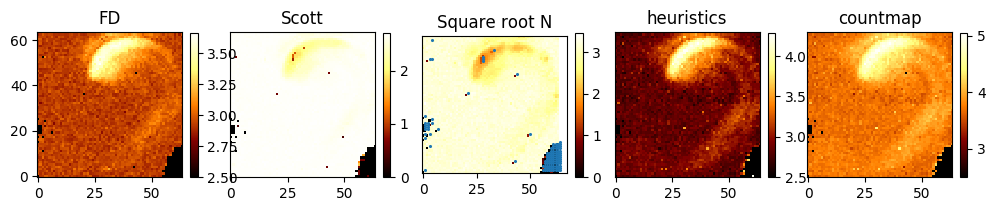

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff6d1fa5748>

In [25]:
fig, (uno, dos, tres, cuatro, cinco)=subplots(1,5, figsize=(12,4))

aa=uno.imshow(comparaentropias[:,:,1], origin="lower", cmap="afmhot", vmin=2.5)
uno.set_title("FD")
colorbar(aa, ax=uno, fraction=0.045)
bb=dos.imshow(comparaentropias[:,:,2], origin="lower",  cmap="afmhot")
dos.set_title("Scott")
dos.set_yticks([])
colorbar(bb, ax=dos, fraction=0.045)
cc=tres.imshow(comparaentropias[:,:,3], origin="lower",  cmap="afmhot")
tres.set_title("Square root N")
tres.set_yticks([])
tres.scatter(malos[:,2], malos[:,1], s=1.5)
colorbar(cc, ax=tres, fraction=0.045)

dd=cuatro.imshow(comparaentropias[:,:,4], origin="lower",  cmap="afmhot", vmin=2.5)
cuatro.set_title("heuristics")
cuatro.set_yticks([])
colorbar(dd, ax=cuatro, fraction=0.045)

dd=cinco.imshow(entrocountmap, origin="lower",  cmap="afmhot", vmin=2.5)
cinco.set_title("countmap")
cinco.set_yticks([])
colorbar(dd, ax=cinco, fraction=0.045)


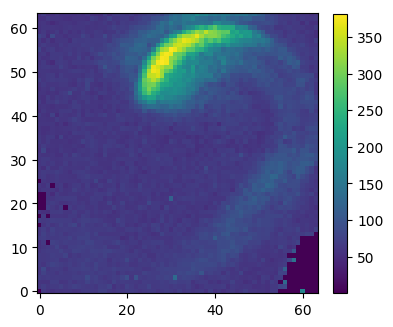

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff6cdc4b208>

In [27]:
ff=figure(figsize=(4,4))
ncuo=imshow(ncountmap, origin="lower")
colorbar(ncuo, fraction=0.045)

In [77]:
lfpex=vec(lfp[5,62,:])
hmalo=histoheuristic(lfpex)[2]
entropy(hmalo.weights)

0

search: entropy crossentropy renyientropy comparaentropias ArgumentError



```
entropy(p, [b])
```

Compute the entropy of a collection of probabilities `p`, optionally specifying a real number `b` such that the entropy is scaled by `1/log(b)`. Elements with probability 0 or 1 add 0 to the entropy.


In [38]:
vernn= fuu.(vernombres)

64×64 Array{Int64,2}:
 4  1  1  2  2  2  1  1  1  1  1  1  1  …  2  1  3  0  0  0  0  0  3  0  0  0
 2  1  1  1  1  1  1  1  1  1  1  1  1     2  1  1  3  3  0  0  0  0  0  0  0
 2  1  2  1  3  1  2  1  1  1  1  3  1     1  1  1  0  3  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  3  1     1  1  1  1  0  0  0  0  0  0  0  0
 1  3  1  1  1  1  1  1  1  2  1  1  1     2  1  2  1  3  0  0  0  0  0  0  0
 1  3  1  1  1  1  1  1  1  3  3  1  1  …  1  1  1  1  1  0  0  0  0  0  0  0
 1  2  1  3  1  1  1  1  1  1  1  1  1     1  1  1  1  1  0  0  0  0  0  0  0
 1  1  1  1  3  1  1  1  1  1  1  1  1     1  2  1  1  1  3  3  0  0  0  0  0
 1  1  3  3  1  1  1  2  1  1  1  1  1     1  1  2  1  1  0  0  0  0  0  0  0
 1  1  3  1  1  3  1  1  3  1  1  3  1     1  1  1  1  1  1  1  0  0  0  0  0
 2  1  1  3  3  1  1  1  1  1  1  3  3  …  2  1  1  3  1  2  1  0  0  0  0  0
 2  2  0  1  1  1  1  1  1  1  1  3  1     2  1  1  1  1  1  1  3  4  0  0  0
 1  1  1  1  1  1  1  3  1  3  1  3  1    

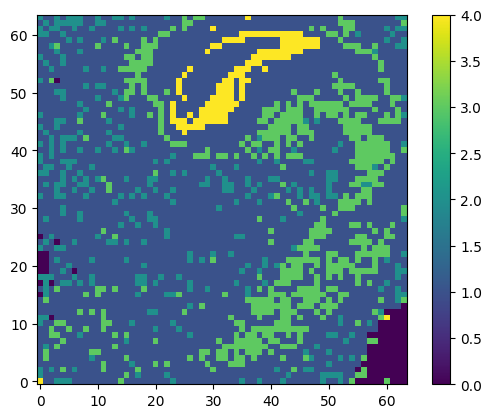

PyObject <matplotlib.colorbar.Colorbar object at 0x7f88d7f87860>

In [40]:
imshow(vernn, origin="lower")
colorbar()

In [48]:
median(verbines[vernombres.=="sig"]), median(verbines[vernombres.=="sb"]),
    median(verbines[vernombres.=="sq"]), median(verbines[vernombres.=="fd"])

(5.076189279556274, 5.065356450968757, 4.4587610366771315, 4.476191931209156)

In [21]:
function sacaentropia1d(datos::Array; deltax=1)
    hh=histoptimo(datos, deltax=deltax)
    pdfs=hh.weights./sum(hh.weights)
    result=entropy(pdfs)
end

sacaentropia1d (generic function with 1 method)

In [22]:
hetas=zeros(64,64)

for j=1:64,k=1:64
    lfpex=vec(lfp[j,k,:])
    hetas[j,k]=sacaentropia1d(lfpex, deltax=2.02)
end

In [36]:
imshow(hetas, origin="lower", vmin=3)
colorbar()
title()

UndefVarError: UndefVarError: hetas not defined

In [24]:
function binsize2d(datosx::Array, datosy::Array; deltax=1, deltay=1)
    if length(datosx)!=length(datosy)
        error("Solo puedo lidiar con datos de la misma longitud")
    end
    
    nn=length(datosx)
    
    minx,maxx=extrema(datosx)
    miny,maxy=extrema(datosy)
    
    rx=maxx-minx
    ry=maxy-miny
    sq=[rx,ry]./(nn^(1/4))
    
    sigx,sigy= std(datosx), std(datosy)
    sc=[sigx,sigy].*(3.49/(nn^(1/6)))

    iqx, iqy= iqr(datosx), iqr(datosy)
    fd=[iqx, iqy].*(2/nn^(1/6))
    
    bines=[sq, sc, fd]
    areas=map(x->prod(x), bines)
    
    losbuenos=areas.>deltax*deltay
    
    areasmayores=areas[losbuenos]
    binesdepurados=bines[losbuenos]
   
    if !isempty(areasmayores)
        index=findmin(areasmayores)[2]
        result=binesdepurados[index]
    else
        result=[deltax,deltay]
    end
    
    return result
end

binsize2d (generic function with 1 method)

In [33]:
function binsize3d(datosx::Array, datosy::Array, datosz::Array; deltax=1, deltay=1, deltaz=1)
    if length(datosx)!=length(datosy) || length(datosx)!=length(datosz)
        error("Solo puedo lidiar con datos de la misma longitud")
    end
    
    nn=length(datosx)
    
    minx,maxx=extrema(datosx)
    miny,maxy=extrema(datosy)
    minz,maxz=extrema(datosy)
    
    rx=maxx-minx
    ry=maxy-miny
    rz=maxz-minz
    sq=[rx,ry, rz]./(nn^(1/6))
    
    sigx,sigy, sigz= std(datosx), std(datosy), std(datosz)
    sc=[sigx,sigy, sigz].*(3.49/(nn^(1/9)))

    iqx, iqy, iqz= iqr(datosx), iqr(datosy), iqr(datosz)
    fd=[iqx, iqy, iqz].*(2/nn^(1/9))
    
    bines=[sq, sc, fd]
    areas=map(x->prod(x), bines)
    
    losbuenos=areas.>deltax*deltay*deltaz
    
    areasmayores=areas[losbuenos]
    binesdepurados=bines[losbuenos]
   
    if !isempty(areasmayores)
        index=findmin(areasmayores)[2]
        result=binesdepurados[index]
    else
        result=[deltax,deltay, deltaz]
    end
    
    return result
end

binsize3d (generic function with 1 method)

In [55]:
lfpx=vec(lfp[51,26,:])
lfpy=vec(lfp[22,30,:])
lfpz=vec(lfp[45,21,:]);

In [56]:
binsize2d(lfpx,lfpy)
binsize3d(lfpx,lfpy,lfpz)

3-element Array{Float64,1}:
 41.54838309197618 
 22.50537417482043 
 27.698922061317454

In [36]:
caralho=zeros(64,64)
for j=1:64, k=1:64
    datos=vec(lfp[j,k,:])
    caralho[j,k]=binsize2d(datos,lfpx)[1]
end

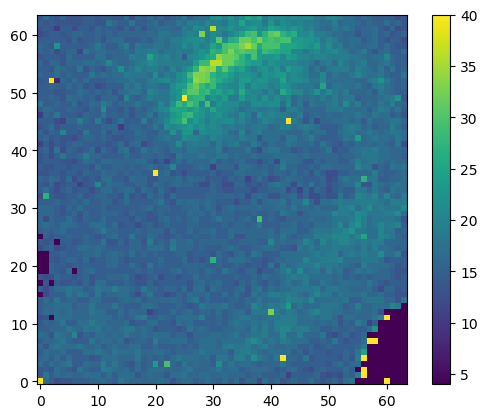

PyObject <matplotlib.colorbar.Colorbar object at 0x7efddaf98dd0>

In [48]:
imshow(caralho,origin="lower",vmin=4, vmax=40)
colorbar()

In [65]:
function histoptimo2d(datosx::Array, datosy::Array; deltax=1, deltay=1)
    bine=binsize2d(datosx, datosy, deltax=deltax, deltay=deltay)
    
    (vxmin,vxmax)=extrema(datosx)
    (vymin,vymax)=extrema(datosy)
    
    rangox=vxmin:bine[1]:vxmax+bine[1]
    rangoy=vymin:bine[2]:vymax+bine[2]
    
    result=fit(Histogram, (datosx, datosy),(rangox, rangoy))
end

function histoptimo3d(datosx::Array, datosy::Array, datosz::Array; deltax=1, deltay=1, deltaz=1)
    bine=binsize3d(datosx, datosy, datosz, deltax=deltax, deltay=deltay, deltaz=deltaz)
    
    (vxmin,vxmax)=extrema(datosx)
    (vymin,vymax)=extrema(datosy)
    (vzmin,vzmax)=extrema(datosz)
    
    rangox=vxmin:bine[1]:vxmax+bine[1]
    rangoy=vymin:bine[2]:vymax+bine[2]
    rangoz=vzmin:bine[3]:vzmax+bine[3]
    
    result=fit(Histogram, (datosx, datosy, datosz),(rangox, rangoy, rangoz))
end

histoptimo3d (generic function with 1 method)

In [66]:
ff=histoptimo3d(lfpx, lfpy,lfpz;deltax=3, deltay=3, deltaz=3)

Histogram{Int64,3,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  -942.626953125:41.54838309197618:802.4051367379993
  -70.49560546875:22.50537417482043:64.53663958017259
  -88.623046875:27.698922061317454:77.57048549290471
weights: [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 1 … 0 0]

[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
closed: left
isdensity: false

In [68]:
sum(ff.weights)

2000

In [24]:
caralho=Dict{Array, Any}()
for q in ejemplos
    caralho[q]=histofreediaconis(lfp[q[1], q[2], :])
end

1 Base.TwicePrecision{Float64}(0.4607807661920545, 0.0)
159.8500616351135 17.0 [58, 30] 2051.0 0.4607807661920545
1 Base.TwicePrecision{Float64}(0.3523617623821593, 0.0)
13304.115182497977 13.0 [56, 41] 2049.0 0.3523617623821593
1 Base.TwicePrecision{Float64}(0.4065712642871069, 0.0)
11412.924181035947 15.0 [54, 36] 2049.0 0.4065712642871069
1

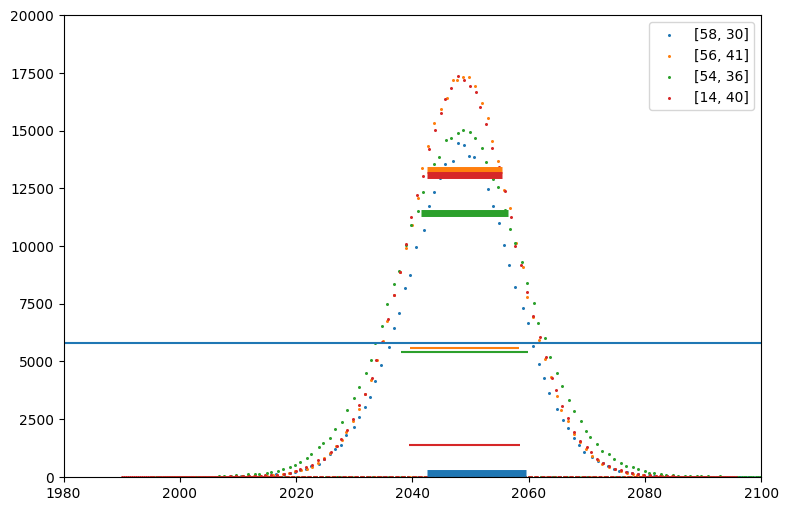

 Base.TwicePrecision{Float64}(0.3523617623821593, 0.0)
13065.98283909582 13.0 [14, 40] 2049.0 0.3523617623821593


PyObject <matplotlib.legend.Legend object at 0x7f63e9d39048>

In [100]:
figure(figsize=(9,6))
xlim(1980,2100)
ylim(-20,2.0*10^4)
for q in ejemplos
     lfpex=vec(lfp[q[1], q[2],:])
      sig=std(lfpex)
    inter=iqr(lfpex)
    mm=median(lfpex)
    
    ff=freediaconis(lfpex)
    
    edg=caralho[q].edges[1][1:end-1]
    ww=caralho[q].weights
    aa=scatter(edg,ww, label="$q", s=1.4)
    l=caralho[q].edges[1].step
    println(1, " ", l)
    
    altura=exp(-0.25)/(sig*sqrt(2*pi))
    
    colore=aa.get_facecolors()
    ylin=100*q[1]
    hlines(ylin,mm-sig, mm+sig, color=colore)
    
    ylin2=altura*nmax
    hlines(ylin2, mm-inter/2, mm+inter/2, color=colore, lw=5)
    println(ylin2, " ", inter, " ", q, " ", mm, " ", ff)
end
legend()

In [107]:
for q in ejemplos
    lfpex=vec(lfp[q[1], q[2],:])
    sig=std(lfpex)
    inter=iqr(lfpex)
    mm=median(lfpex)  
    ff=freediaconisbin(lfpex)
    ss=scottbin(lfpex)
    sq=sqrbin(lfpex)
    println(q, " ", sig, " ", inter, " ", mm, " ", ff ,  " ", ss, " ", sq)
end

[58, 30] 780.8675233622242 17.0 2051.0 0.4607807661920545 36.93330845957613 3.3052717032174175
[56, 41] 9.382188896148257 13.0 2049.0 0.3523617623821593 0.44375680401644035 0.14830336043075762
[54, 36] 10.936874700851641 15.0 2049.0 0.4065712642871069 0.5172900073639164 0.18143496222911837
[14, 40] 9.553182739902311 13.0 2049.0 0.3523617623821593 0.4518444350000733 0.1672357043155352


[58, 30] 780.8675233622242 17.0
[56, 41] 9.382188896148257 13.0
[54, 36] 10.936874700851641 15.0


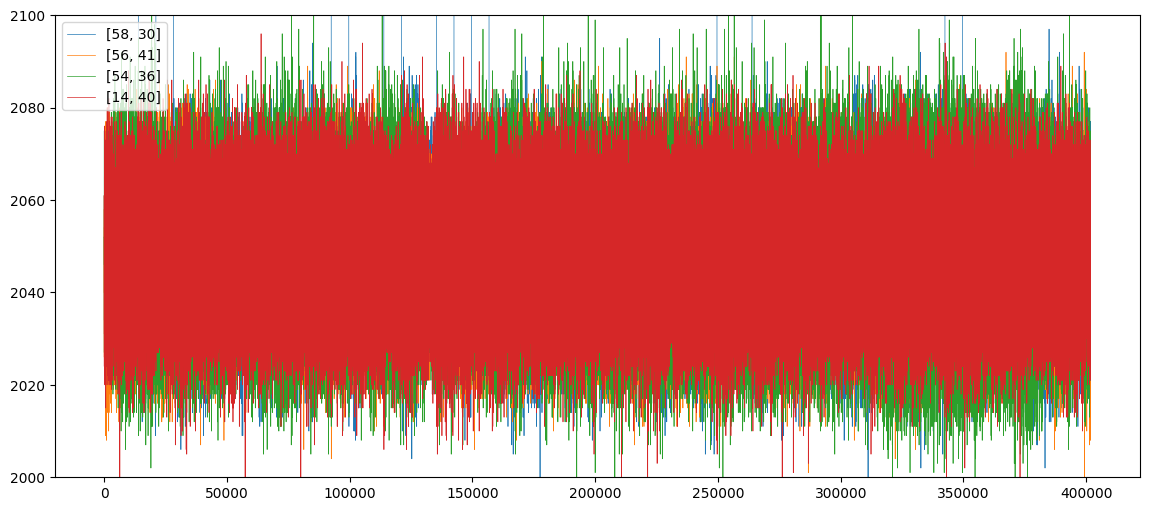

[14, 40] 9.553182739902311 13.0


PyObject <matplotlib.legend.Legend object at 0x7f63eb2da320>

In [54]:
figure(figsize=(14,6))
ylim(2000,2100)
for q in ejemplos
    lfpex=vec(lfp[q[1], q[2],:])
    rangg=collect(1:nmax)
    plot(rangg, lfpex, lw=0.5, label="$q")
    sig=std(lfpex)
    inter=iqr(lfpex)
    println(q, " ", sig, " ", inter)
end
legend()

In [15]:
uno=sum(rr3.weights, dims=[1,3])
otro=rryy.weights
vec(uno)==otro
(typeof(uno), typeof(otro))

(Array{Int64,3}, Array{Int64,1})

In [16]:
fururu=[rrr.edges[2][1], rrr.edges[2][end], rrr.edges[1][1], rrr.edges[1][end]]
f9=[0,1,0,1]
imshow(rrr.weights./sum(rrr.weights), extent=fururu, origin="lower", interpolation="nearest")
colorbar()
#scatter(yy,xx, c="red", s=1)

UndefVarError: UndefVarError: rrr not defined

In [17]:
function transferentropyfd(yyfuture::Array, yypast::Array, xxpast::Array)
    hfd=histofreediaconis(yyfuture,yypast,xxpast)
    pesos=hfd.weights./sum(hfd.weights)
    #checa que conserva su "dimensionalidad" en los indices
    pypast=sum(pesos, dims=[1,3])
    pypastxpast=sum(pesos, dims=1)
    pyfutpypast=sum(pesos, dims=3)

    (KK,LL,MM)=size(pesos)
    
    sumatum=0
    
    for k=1:KK, l=1:LL, m=1:MM
        aux1=pesos[k,l,m]*pypast[1,l,1]
        aux2=pypastxpast[1,l,m]*pyfutpypast[k,l,1]
        if aux1 !=0  && aux2 !=0
            aux3=log(aux1/aux2)
            sumatum+=pesos[k,l,m]*aux3
        end
    end
    
    return sumatum
    
end


transferentropyfd (generic function with 1 method)

In [18]:
tau=round(Int, 5*freq)
xx=lfp[56,30,:]
yy=lfp[56,40,:]
xf=xx[tau:end]
xp=xx[1:end-tau+1]
yp=yy[1:end-tau+1]
transferentropyfd(xf,xp,yp)

1.2312138905946999

In [19]:
rrr=histofreediaconis(xx,yy)
rx=sum(rrr.weights, dims=2)
ry=sum(rrr.weights, dims=1)

1×86 Array{Int64,2}:
 2  0  1  2  1  1  1  1  1  4  1  3  2  …  0  3  2  1  0  1  0  1  1  1  0  2

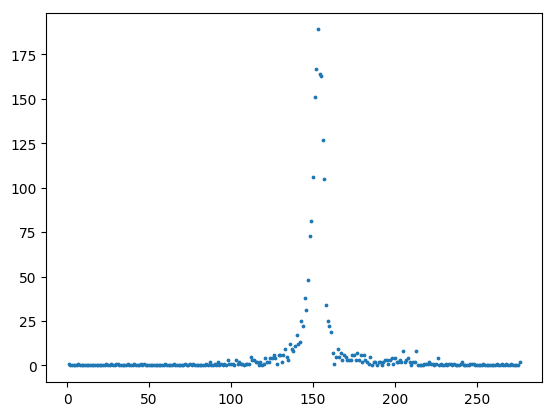

PyObject <matplotlib.collections.PathCollection object at 0x7fd578518c88>

In [20]:
scatter(1:length(rx),vec(rx), s=3)

In [68]:
function histocountmap(xxs::Array)
    dicto=countmap(xxs)
    ll=length(dicto)
    bla=zeros(ll,2)
    j=1
    for k in sort(collect(keys(dicto)))
        bla[j,1]=k
        bla[j,2]=dicto[k]
        j+=1
    end
    return bla
end

function histocountmap(xxss::Array...)
    valores=collect(zip(xxss...))
    dicto=countmap(valores)
    ll=length(dicto)
    tantas=length(xxss)
    bla=zeros(ll, tantas+1)
    j=1
    for k in sort(collect(keys(dicto)))
        for l in 1:tantas
            bla[j,l]=k[l]
        end
        bla[j,tantas+1]=dicto[k]
        j+=1
    end
    return bla
end

LoadError: syntax: incomplete: "function" at none:1 requires end

In [72]:
rangg=250:1500
xxpas=xx[rangg]
yypas=yy[rangg]
yyfut=yy[rangg.+28];

In [76]:
haha=histocountmap(yyfut,yypas,xxpas)
countmap(haha[:,end])

Dict{Float64,Int64} with 2 entries:
  2.0 => 4
  1.0 => 1243

In [22]:
function entrocountmap(xxs::Array)
    cuentas=histocountmap(xxs)
    pdfval=cuentas[:,2]./sum(cuentas[:,2])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end

function entrocountmap(xxss::Array...)
    cuentas=histocountmap(xxss...)
    #ligeramente diferente ¿sera generalizable?
    pdfval=cuentas[:,end]./sum(cuentas[:,end])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end


entrocountmap (generic function with 2 methods)

In [ ]:
function transferentropycm(yyfuture, yypast, xxpast)
    hcm=histocountmap(yyfuture,yypast,xxpast)
    pesos=hcm[:,end]
    pesos=pesos./sum(pesos)
    #checa que conserva su "dimensionalidad" en los indices
    pypast=histocountmap(yypast)
    pypastxpast=histocountmap(yypast,xxpast)
    pyfutpypast=histocountmap(yyfuture,yypast)
    
    

    (KK,LL,MM)=size(pesos)
    
    sumatum=0
    
    for k=1:KK, l=1:LL, m=1:MM
        aux1=pesos[k,l,m]*pypast[1,l,1]
        aux2=pypastxpast[1,l,m]*pyfutpypast[k,l,1]
        if aux1 !=0  && aux2 !=0
            aux3=log(aux1/aux2)
            sumatum+=pesos[k,l,m]*aux3
        end
    end
    
    return sumatum
    


end

In [23]:
fu=histocountmap(xx,yy)
bar=entrocountmap(xx,yy)

7.258144577604487

In [25]:
fufu=fu[fu[:,3].>2,:]
typeof(fufu)

Array{Float64,2}

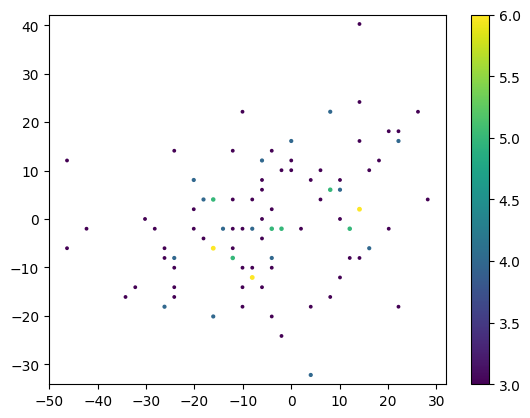

(-50.053800503667674, 31.926359097417667, -35.85500884745723, 43.91128698707785)

In [26]:
eqs=fufu[:,1]
yes=fufu[:,2]
siz=fufu[:,3]
scatter(eqs,yes, s=siz, c=siz)
colorbar()
axis("equal")

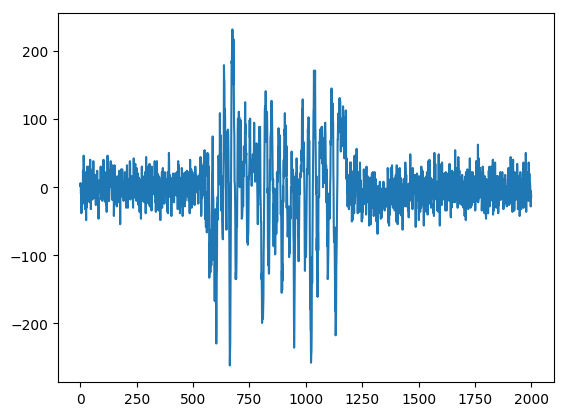

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5767bdf60>

In [27]:
plot(yy)

In [28]:
hetasfd=zeros(64,64)
hetascm=zeros(64,64)
for j=1:64, k=1:64
    ejemplo=lfp[j,k,:]
    hetasfd[j,k]=sacaentropiafd(ejemplo)
    hetascm[j,k]=entrocountmap(ejemplo)
end


In [29]:
dh=hetasfd-hetascm;
#map!(x->round(x ;digits=3), dh)

64×64 Array{Float64,2}:
 -0.00430033  -0.828288  -0.721642  …   0.0        0.0        0.0     
 -0.645778    -0.949897  -0.725919      0.0        0.0        0.0     
 -0.655579    -0.727874  -0.656125      0.0        0.0        0.0     
 -0.873623    -0.722449  -0.883149      0.0        0.0        0.0     
 -0.809698    -0.879922  -0.726231      0.0        0.0        0.0     
 -0.736013    -0.870958  -0.80382   …   0.0        0.0        0.0     
 -0.801438    -0.650344  -0.86598       0.0        0.0        0.0     
 -0.725109    -0.795596  -0.802805      0.0        0.0        0.0     
 -0.868443    -0.815723  -0.648623      0.0        0.0        0.0     
 -0.742314    -0.729287  -0.814583      0.0        0.0        0.0     
 -0.654961    -0.798873  -0.742495  …   0.0        0.0        0.0     
 -0.593115    -0.645372   0.0           0.0        0.0        0.0     
 -0.7153      -0.884071  -0.793444      0.0        0.0        0.0     
  ⋮                                 ⋱                

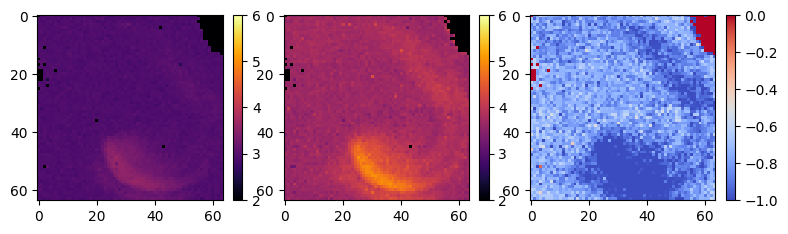

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd576608f28>

In [30]:
fig, (uno, dos, tres)=subplots(1,3, figsize=(9,4))
bmin=2
bmax=6
fafa=uno.imshow(hetasfd, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fafa, ax=uno, fraction=0.045)
fufu=dos.imshow(hetascm, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fufu, ax=dos, fraction=0.045)
fefe=tres.imshow(dh, origin="upper", cmap="coolwarm", vmin=-1, vmax=0)
colorbar(fefe, ax=tres, fraction=0.045)


In [31]:
mean(hetascm)

3.7399459847198226

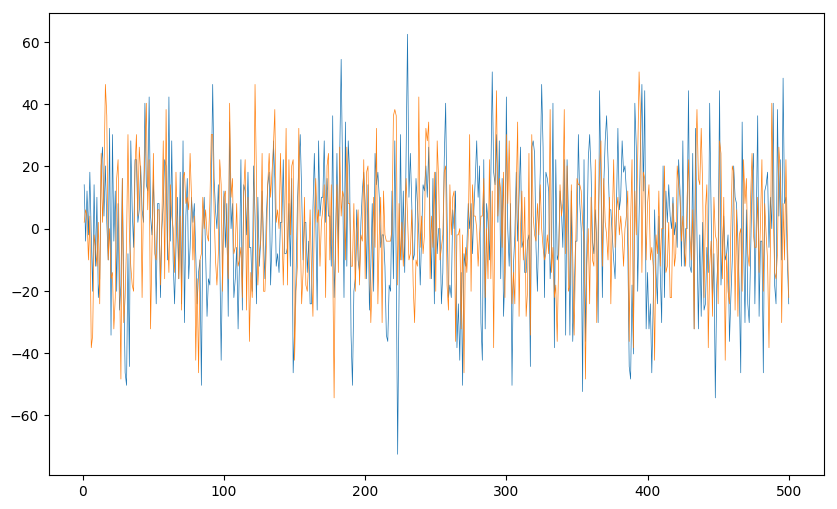

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd57680e2e8>

In [32]:
f=figure(figsize=(10,6))
rang=1:5*10^2
plot(rang,xx[rang], lw=0.5)
plot(rang,yy[rang], lw=0.5)

In [33]:
vallfpdisc=zeros(64,64)
hfdiacounts=zeros(64,64)
iqrs=zeros(64,64)
for j=1:64, k=1:64
    haux=0
    try
        haux=histofreediaconis(lfp[j,k,:])
          hfdiacounts[j,k]=length(haux.edges[1])
    catch e
    end
    iqrs[j,k]=iqr(lfp[j,k,:])
  
    vallfpdisc[j,k]=length(countmap(lfp[j,k,:]))
end

In [34]:
iqr(vec(iqrs))
mean(vec(iqrs))
mode(vec(iqrs))


26.18408203125

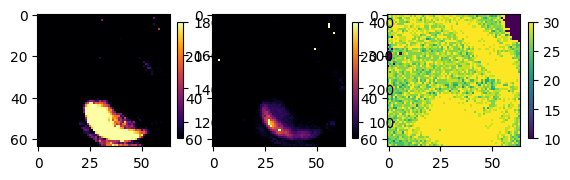

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5764e3b38>

In [35]:
figure(figsize=(12,8))
fig, (uno, dos,tres)=subplots(1,3)
fafa=uno.imshow(vallfpdisc, origin="upper", vmin=110, vmax=180, cmap="inferno")
colorbar(fafa, ax=uno, fraction=0.04)
fufu=dos.imshow(hfdiacounts, origin="upper", vmin=50, vmax=400, cmap="inferno")
colorbar(fufu, ax=dos, fraction=0.04)
fefe=tres.imshow(iqrs, vmin=10,vmax=30)
colorbar(fefe, ax=tres, fraction=0.04)


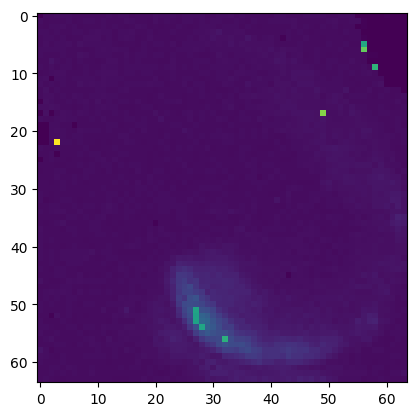

PyObject <matplotlib.image.AxesImage object at 0x7fd57640dcc0>

In [36]:
imshow(hfdiacounts)

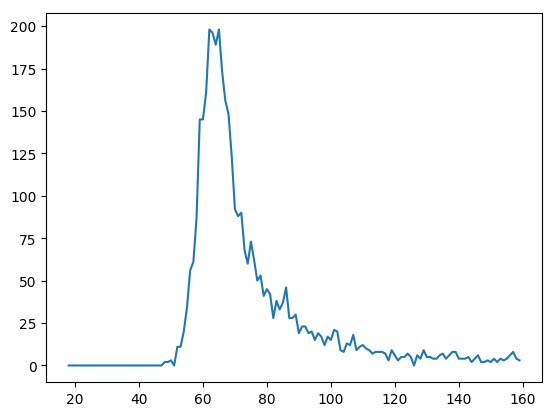

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5763f4320>

In [37]:
vv=vec(vallfpdisc)
ll=length(countmap(vv))
jhh=fit(Histogram, vv, 18:160)
ta=jhh.weights
tu=jhh.edges[1]
size(collect(tu[1:end-1])), size(ta)
plot(tu[1:end-1], ta)

In [38]:
typeof(vv)

Array{Float64,1}

In [55]:
function sacaentropiafd(datosX::Array, datosY::Array)
    # ambos arrays deben ser igual de largos ???
    binsizeX=freediaconis(datosX)
    binsizeY=freediaconis(datosY)
    if (binsizeX==0 || binsizeY==0)
        error(" ¡Esto que, no tiene variacion en los datos!")
    else
        (viX,vfX)=extrema(datosX)
        (viY,vfY)=extrema(datosY)
        rangoX=viX:binsizeX:vfX
        rangoY=viY:binsizeY:vfY
        
        histodo=fit(Histogram, (datosX, datosY), (rangoX, rangoY))
        
        pdf=histodo.weights
        pdf=pdf./sum(pdf)
        result=entropy(pdf)
        return result
        #return (result, histodo)
    end

end

sacaentropiafd (generic function with 2 methods)

In [56]:
function infomutua(datosX::Array, datosY::Array)
    hetaX=sacaentropiafd(datosX)
    hetaY=sacaentropiafd(datosY)
    hetaXY=sacaentropiafd(datosX,datosY)
    result=hetaX+hetaY-hetaXY
    return result
end

infomutua (generic function with 1 method)

In [57]:
nchan=size(orderchans, 1)
hetas=zeros(nchan)
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    hetas[j]=sacaentropiafd(vec(ejemplo))
end

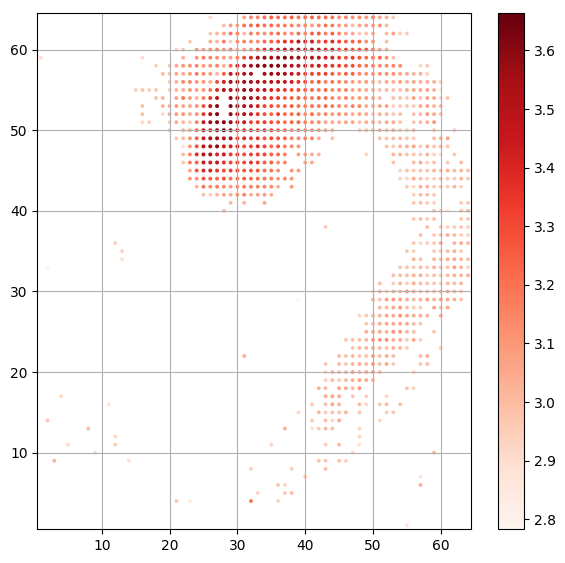

In [58]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=hetas, c=hetas, cmap="Reds")
colorbar()
grid()

In [59]:
hetacut=quantile(hetas, 0.90)
tuabueta=findall(x->x>hetacut,hetas);
auxchans=hcat(orderchans[tuabueta,:], hetas[tuabueta])
naux=size(auxchans,1)

105

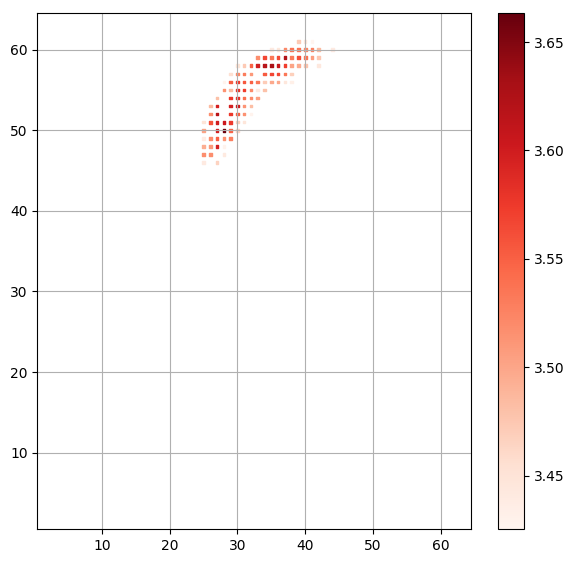

In [60]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(auxchans[:,2], auxchans[:,1], s=auxchans[:,4], 
    c=auxchans[:,4],marker="s", cmap="Reds")
colorbar()
grid()

In [61]:
imutres=zeros(nchan)
refe=[50,28]
fijo=lfp[refe[1], refe[2],:]
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    imutres[j]=infomutua(fijo, ejemplo)
end

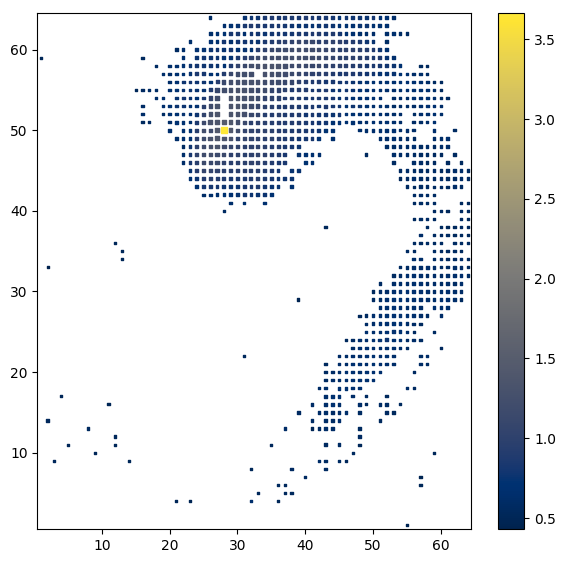

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd576239358>

In [62]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=imutres.*5, c=imutres, cmap="cividis", marker="s")
colorbar()
#grid()

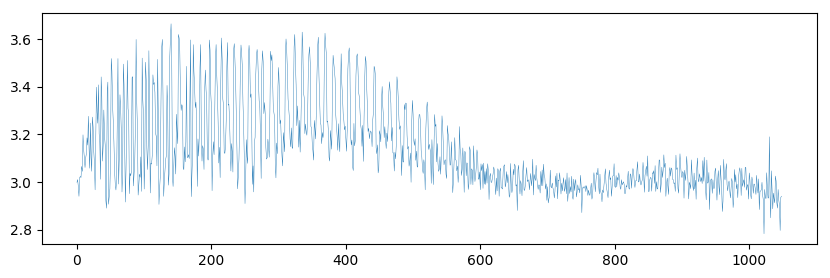

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd57631fac8>

In [63]:
figure(figsize=(10,3))
plot(hetas, lw=0.3)

In [64]:
mutinfo=zeros(naux,naux);
crossentro=zeros(naux,naux)

@time for j=1:naux
    for k=j:naux
        
        reng1,col1=(auxchans[j,1], auxchans[j,2])
        reng2,col2=(auxchans[k,1], auxchans[k,2])
        
        reng1=round(Int32, reng1)
        reng2=round(Int32, reng2)
        
        col1=round(Int32, col1)
        col2=round(Int32, col2)
        
        
        
        dat1=lfp[reng1, col1,:]
        dat2=lfp[reng2, col2,:]
        
        mutinfo[j,k]=infomutua(dat1,dat2)
        mutinfo[k,j]=mutinfo[j,k]
    
    end
end

  5.966175 seconds (277.01 k allocations: 3.476 GiB, 2.68% gc time)


In [65]:
for j=1:naux
    mutinfo[j,j]=0
end

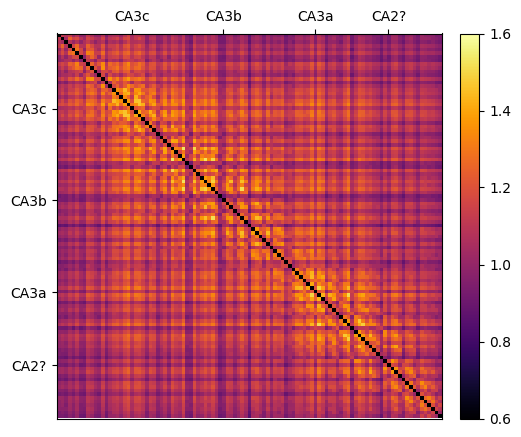

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5789ccda0>

In [66]:
figure(figsize=(6,5))

imshow(mutinfo, cmap="inferno", interpolation="nearest", vmin=0.6, vmax=1.6)

#onde=[55, 125, 200, 250]
onde=[20, 45, 70, 90]
que=["CA3c","CA3b", "CA3a", "CA2?" ]
tick_params(bottom=false, top=true)
xticks(onde, que)
yticks(onde, que)
tick_params(bottom=false, top=true, labeltop=true, labelbottom=false)

colorbar(fraction=0.046, pad=0.04)

In [67]:
?crossentropy

search: crossentropy crossentro



```
crossentropy(p, q, [b])
```

Compute the cross entropy between `p` and `q`, optionally specifying a real number `b` such that the result is scaled by `1/log(b)`.
